We start from an identifier.

In [1]:
identifier = "ABAMIC"
# setup environment variable to use CSD API
import os
os.environ["CSDHOME"] = "/home/qai/CCDC/CSD_2022"

Import methods to convert the identifier to an entry and a chemical diagram.

In [2]:
from chemicaldiagram.converter import export_entry, from_csd_entry_to_diagram, get_entry_from_identifier
entry = get_entry_from_identifier(identifier)
entry_dict = export_entry(entry)
chemical_diagram = from_csd_entry_to_diagram(entry)

`entry_dict` contains (almost) all information in the `ccdc.io.Entry` object,
when generating a dataset,
it is advised to always use information from this dictionary to be consistent.
(For example, `CIF` uploaded to `CSD` may be different from the one obtained from `CSD API`)

In [3]:
entry_dict

{'cif_string': "\n#######################################################################\n#\n#                 Cambridge Crystallographic Data Centre\n#                                CCDC \n#\n#######################################################################\n#\n# If this CIF has been generated from an entry in the Cambridge \n# Structural Database, then it will include bibliographic, chemical, \n# crystal, experimental, refinement or atomic coordinate data resulting \n# from the CCDC's data processing and validation procedures.\n#\n#######################################################################\n\ndata_ABAMIC\n_audit_creation_date             2016-11-22\n_database_code_depnum_ccdc_archive 'CCDC 1409549'\n_database_code_CSD               ABAMIC\n_chemical_formula_moiety         '(H3 O11 P3 V2 2-)n,C6 H16 N2 2+'\n_chemical_name_systematic        \n'catena-[1,4-dimethylpiperazinediium tris(\\m-phosphonato)-dioxo-di-vanadium]'\n_journal_coden_Cambridge         208\n_journa

Sometimes it's easier to work with an object

In [ ]:
from chemicaldiagram.diagram import ExportedEntry
exported_entry = ExportedEntry.from_dict(entry_dict)

Now let's look at the `ChemicalDiagram` object.

In [4]:
chemical_diagram

ChemicalDiagram: C6 H19 N2 O11 P3 V2 ; charge: 0.

All info are stored as a `networkx.Graph` object.

In [5]:
chemical_diagram.graph

The drawing (calculated 2d coordinates) from `CSD` is also stored.

/home/qai/anaconda3/envs/chemicaldiagram/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
  alpha=alpha,


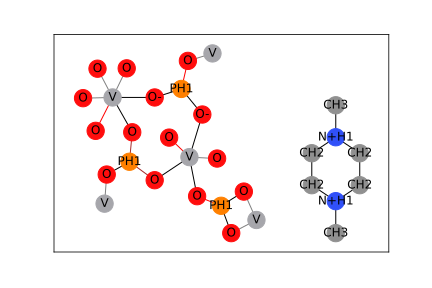

In [6]:
from IPython.core.display import SVG
SVG(data=chemical_diagram.draw_svgdata())

Note in the above figure edges are colored by `CSD API` annotations.
Gray edges indicating bonds running across the unit cell boundary.

In [7]:
from chemicaldiagram.diagram import _edges_color_in_drawing
_edges_color_in_drawing

{0: ('yellow', 'unknown'),
 1: ('black', 'single'),
 2: ('red', 'double'),
 3: ('blue', 'triple'),
 4: ('green', 'quadruple'),
 5: ('pink', 'aromatic'),
 7: ('brown', 'delocalized'),
 9: ('purple', 'pi')}

Now look at the connected components and their building units. We expect `VO5`, `VO6` and `HPO3`.

In [8]:
from chemicaldiagram import BuildingUnitDiagram
sub_diagrams = chemical_diagram.get_components()
print("Sub diagrams:")
for sd in sub_diagrams:
    print("\t", sd)
    print("\t\tBuilding Units:", BuildingUnitDiagram.get_pbus_from_diagram(sd))

Sub diagrams:
	 ChemicalDiagram: H3 O11 P3 V2 ; charge: -2.
		Building Units: [BuildingUnitDiagram: O6 V1 ; charge: -1., BuildingUnitDiagram: O5 V1 ; charge: -1., BuildingUnitDiagram: H1 O3 P1 ; charge: -2., BuildingUnitDiagram: H1 O3 P1 ; charge: 0., BuildingUnitDiagram: H1 O3 P1 ; charge: 0.]
	 ChemicalDiagram: C6 H16 N2 ; charge: 2.
		Building Units: [BuildingUnitDiagram: C6 H16 N2 ; charge: 2.]


`ChemicalDiagram` also allows filtering structures based on subgraph isomorphism.
The reason to use this rather than `ConQuest` is, still, to avoid inconsistency,
as the "same" entry from `CSD API`, `WEB-CSD` and `CSD-system` may not be identical to each other.
Also, you can add very complex conditions using graph-based functions.
See [export_oxide](./export_oxide.py) for more examples.

In [10]:
from chemicaldiagram import ChemicalDiagramFilter, ChemicalDiagram

# define subgraph inclusion/exclusion rules
rules = """line graph inclusion: any C-N-H,
line graph exclusion: any O-P-C,"""
inclusion_subgraphs, exclusion_subgraphs = ChemicalDiagramFilter.generate_subgraph_rules(rules)

# define a condition as a ChemicalDiagram -> bool function
def cdf_condition(cd: ChemicalDiagram):
    """must be a charge neutral structure"""
    return cd.total_charge == 0

# create a filter for ChemicalDiagram
cdf = ChemicalDiagramFilter(inclusion_subgraphs, exclusion_subgraphs, [cdf_condition, ])
# turn on logging
import logging
logging.getLogger().setLevel(logging.INFO)
accept = cdf.accept(chemical_diagram)
print(accept)


INFO:root:pass: must be a charge neutral structure
INFO:root:pass: line graph inclusion: any C-N-H
INFO:root:pass: line graph exclusion: any O-P-C


True
